# Cholera

In [1]:

import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
import itertools
import numpy as onp

import jax.numpy as np
import ipywidgets as widgets
import pandas as pd

from jax.numpy.linalg import inv, pinv
from jax.scipy.optimize import minimize
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm.notebook import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

from pomps import *
from resampling import *
from filtering import *
from optim import *


import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
onp.set_printoptions(suppress=True)

2024-07-18 20:48:08.086708: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = pd.read_csv('data/dacca/dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
dataset = pd.read_csv('data/dacca/covars.csv', index_col=0).reset_index(drop=True)
dataset.index = pd.read_csv('data/dacca/covart.csv', index_col=0).reset_index(drop=True).squeeze()
dataset = dataset.reindex(onp.array([1891 + i*(1/240) for i in range(12037)])).interpolate()
covars = np.array(dataset.values)#[20:]
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 8.0, 9.238, 7.1, 0.7, onp.exp(-4.5), 0.0051, (-6.8*10**(-3)), 639.6, 0.23, np.array([6.5,11.4,2.1,9.0,8.6,9.5]), 3, 0.02
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 17.3, 0.057, 0, 9.8, onp.exp(-4.8), 0.999999, (-5.0*10**(-3)), 3.2, 0.25, np.array([1.2,6.2,-3.4,3.9,3.2,4.3]), 3, 0.02


gamma = 20.8
epsilon = 19.1
rho = 0
delta = 0.02
m = 0.06
c = np.array(1)
beta_trend = -0.00498
bs = np.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13 #3.13 # 0.77
tau = 0.23 
omega = onp.exp(-4.5)
omegas = np.log(np.array([0.184, 0.0786, 0.0584, 0.00917, 0.000208, 0.0124]))


theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)

2024-07-18 20:48:12.209723: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
pfilter(theta, ys, 10000, covars, thresh=-1)

Array(3747.9526, dtype=float32)

In [3]:
mop(theta, ys, 10000, covars, alpha=0.5)

Array(3749.1624, dtype=float32)

In [3]:
n_trials = 100
J = 10000

def get_rand_theta():
    return transform_thetas(onp.random.uniform(10.00, 40.00),
                onp.random.uniform(0.03, 0.60), 
                         rho, 
                 onp.random.uniform(0.20, 30.00), 
                         omega, 
                         c, 
                 onp.random.uniform(-1.00, 0.00)*0.01, 
                 onp.random.uniform(1.00, 5.00), 
                 onp.random.uniform(0.10, 0.50), 
                 onp.random.uniform(0,8,size=6)+np.array([-4,0,-4,0,0,0]), 
                 onp.random.uniform(-10,0,size=6))

def get_sds():    
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    return (highs-lows)/100



def get_rand_theta(J=J):
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    rands = onp.array(onp.repeat(((lows+highs)/2)[None,:], J, axis=0)).T
    rands[~onp.isinf(lows)] = onp.random.uniform(lows[~onp.isinf(lows)], 
                       highs[~onp.isinf(highs)],
                       size=(J, len(highs[~onp.isinf(highs)]))).T
    return rands.T
                       
                       


sigmas = (np.abs(theta)/600)
theta_ests = theta + 60*sigmas*onp.random.normal(size=theta.shape) #6 for close to maxima
#theta_ests = get_rand_theta(J).mean(0)

'''
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=5e-4/600,
                            verbose=True, itns=20, J=J, thresh=0, method='SGD', scale=False)


newt_logliks, newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=0, method='Newton', scale=True, ls=True)

'''
print(pfilter(theta_ests, ys, J, covars, thresh=-1))
#res = minimize(pfilter, x0=theta_ests, args=(ys, J, covars, 0), method='BFGS', options={'maxiter': 10})
get_thetas(theta_ests)

# try cross-comparison, fig 2 in pnas, on close to MLE
# use if2 settings

3836.1968


(Array(18.937346, dtype=float32),
 Array(0.08648736, dtype=float32),
 Array(nan, dtype=float32),
 Array(27.852173, dtype=float32),
 Array(0.01153238, dtype=float32),
 Array(nan, dtype=float32),
 Array(-0.00561499, dtype=float32),
 Array(3.3110685, dtype=float32),
 Array(0.2680654, dtype=float32),
 Array([ 0.80502206,  6.603713  , -3.2063866 ,  4.3642726 ,  3.5725431 ,
         4.2249985 ], dtype=float32),
 Array([-1.9404441, -2.7395008, -3.1769166, -4.5655956, -8.664423 ,
        -4.1325545], dtype=float32),
 3,
 0.02)

In [4]:
def log_in_bbox(theta):    
    valids = np.array([i for i in range(len(theta)) if i not in [2,5]])
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    #theta = highs+1
    #theta = lows-1
    return -100*np.log(1-(np.logical_or(np.any(lows[valids] > theta[valids]),
                                        np.any(theta[valids] > highs[valids])))+1e-43)

log_in_bbox(theta+9999)

Array(9901.625, dtype=float32, weak_type=True)

In [ ]:
mop_grads = [[jgrad_mop(theta, 
                   ys, J, covars, alpha, jax.random.PRNGKey(i))
             for i in tqdm(range(1000))] 
             for alpha in [0,0.1,0.3,0.5,0.7,0.8,0.85,0.9,0.95,0.975,0.99,1]]

dpf_grads = [jgrad(theta, 
                   ys, J, covars, -1, jax.random.PRNGKey(i))
             for i in tqdm(range(1000))]

pf_grads = [jgrad_pf(theta, 
                   ys, J, covars, -1, jax.random.PRNGKey(i))
             for i in tqdm(range(1000))]

  0%|          | 0/1000 [00:00<?, ?it/s]

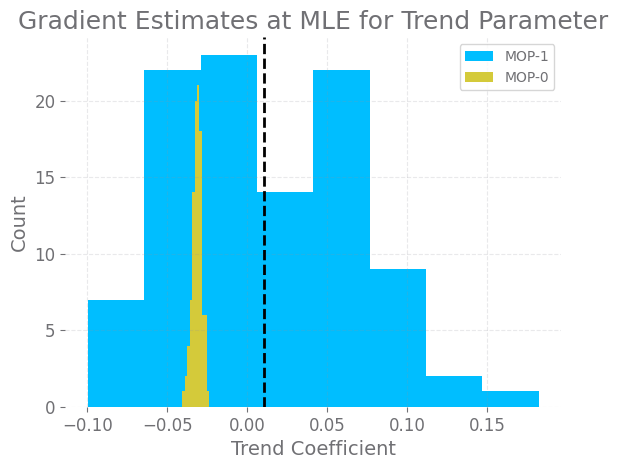

In [133]:
col = 6
#norm_dpf = np.array(dpf_grads)/np.linalg.norm(np.array(dpf_grads), axis=1)[:,None]
#norm_pf = np.array(pf_grads)/np.linalg.norm(np.array(pf_grads), axis=1)[:,None]
norm_dpf = np.array(dpf_grads)
norm_pf = np.array(pf_grads)
plt.hist(norm_dpf[:,col], label='MOP-1', bins='auto')
plt.axvline(norm_dpf[:,col].mean(), color='black', linestyle='--')
plt.hist(norm_pf[:,col], label='MOP-0', bins='auto')
plt.legend()
plt.title('Gradient Estimates at MLE for Trend Parameter')
plt.xlabel('Trend Coefficient')
plt.ylabel('Count')
plt.savefig('imgs/mlegrad.png')
plt.show()

In [ ]:
alphas_orig = [0,0.1,0.3,0.5,0.7,0.8,0.85,0.9,0.95,0.975,0.99,1]
variance_alphas = np.array([np.var(np.array(mop_grads[i]),axis=0).sum() 
                            for i in range(len(mop_grads))])
mse_alphas = np.array([np.mean(np.sum(np.array(mop_grads[i])**2,1)) for i in range(len(mop_grads))])
bias_alphas = np.array([(np.array(mop_grads[i]).mean(0)**2).sum() for i in range(len(mop_grads))])
plt.figure((5,4))
plt.plot(alphas_orig,mse_alphas,
         label='MSE')
plt.plot(alphas_orig,bias_alphas,
         label='Squared Bias')
plt.plot(alphas_orig,variance_alphas,
         label='Variance')
plt.legend()
plt.title('Bias-Variance Tradeoff for Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE/Variance/Bias')
plt.savefig('imgs/095/biasvar.png', dpi=300)

Text(0, 0.5, 'MSE/Variance/Bias')

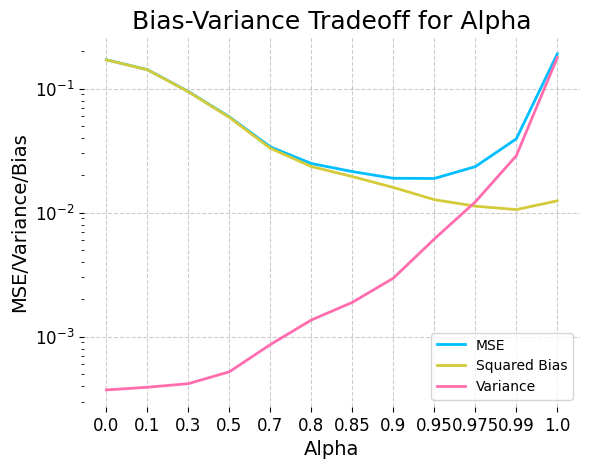

In [40]:
alphas_orig = np.array([0,0.1,0.3,0.5,0.7,0.8,0.85,0.9,0.95,0.975,0.99,1])
variance_alphas = np.array([np.var(np.array(mop_grads[i]),axis=0).sum() 
                            for i in range(len(mop_grads))])
mse_alphas = np.array([np.mean(np.sum(np.array(mop_grads[i])**2,1)) for i in range(len(mop_grads))])
bias_alphas = np.array([(np.array(mop_grads[i]).mean(0)**2).sum() for i in range(len(mop_grads))])
plt.figure((5,4))
plt.plot(mse_alphas,
         label='MSE')
plt.plot(bias_alphas,
         label='Squared Bias')
plt.plot(variance_alphas,
         label='Variance')
#plt.xscale('symlog')
plt.yscale('log')
plt.xticks(np.arange(len(alphas_orig)), alphas_orig)
plt.legend()
plt.title('Bias-Variance Tradeoff for Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE/Variance/Bias')